In [79]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import gauss, seed
from scipy import stats
import seaborn as sns
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm

%matplotlib inline

In [80]:
df1 = pd.read_csv("data/tanzania_wells.csv", index_col = 0)

In [81]:
df1.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


#mapping grade map
grade_map = {'3 Poor': 3,
             '4 Low': 4,
             '5 Fair': 5,
             '6 Low Average': 6,
             '7 Average': 7,
             '8 Good': 8,
             '9 Better': 9,
             '10 Very Good': 10,
             '11 Excellent': 11,
             '12 Luxury': 12,
             '13 Mansion': 13}

#adding in to train_kch
train_kch['grade_num'] = train_kch['grade'].map(grade_map)
train_kch.drop('grade', axis = 1, inplace=True);

In [165]:
# Examining our target
df1['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

# Finding what features to include / drop

Dropping: 
    date_recorded (This is not helpful because this is the date that the data was entered. Metadata) 
    wpt_name (Geographic information. Useful for qualitative analysis. Not useful for modeling, but could be useful in future steps.) 
    num_private (No information in the data dictionary, and not interpretable from looking at it.)
    region_code (Removing as we don't know how these are coded.)
    district_code (Removing as we do not know where these locations are.)
    public_meeting (Dropping. Data documentation is unclear on what this is and further investigation is required.)
    recorded_by (No insights to be gained from this.)
    scheme_name (Dropping due to excessive categorical data. Not useful for analysis.)
    extraction_type (Dropping in exchange for extraction_type_class.)
    extraction_type_group (Dropping in exchange for extraction_type_class.)
    management_group (Dropping for management as this one does not have a better breakdown of managers of the wells.)
    payment (Dropping this one for payment type as these category names are less clear.)
    water_quality (Dropping because it doesn't consolidate the categories as much as water_quality)
    quantity_group (Dropping over quantity group as they are duplicates.)
    source (Dropping because too much information.)
    source_class (Dropping because there is too little information.)
    waterpoint_type_group (Dropping for waterpoint_type.)

In [82]:
df1['amount_tsh'].value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

In [83]:
df1['date_recorded'].value_counts()

2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-17      1
2011-09-18      1
2011-09-05      1
2011-09-23      1
2011-08-30      1
Name: date_recorded, Length: 356, dtype: int64

In [84]:
df1['funder'].value_counts()

Government Of Tanzania           9084
Danida                           3114
Hesawa                           2202
Rwssp                            1374
World Bank                       1349
                                 ... 
Domestic Rural Development Pr       1
Kwaruhombo He                       1
Kegocha                             1
Mzee Yassin Naya                    1
Sindida Yetu                        1
Name: funder, Length: 1897, dtype: int64

In [85]:
df1['gps_height'].value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

In [86]:
df1['installer'].value_counts()

DWE                     17402
Government               1825
RWE                      1206
Commu                    1060
DANIDA                   1050
                        ...  
Mwakabalula                 1
Mh.chiza                    1
DW#                         1
Samwel                      1
Ramadhani M. Mvugalo        1
Name: installer, Length: 2145, dtype: int64

In [87]:
# Geographic information. Not useful for modeling, but could be useful in future steps.
df1['wpt_name'].value_counts()

none                     3563
Shuleni                  1748
Zahanati                  830
Msikitini                 535
Kanisani                  323
                         ... 
Kwa Zuberi Mpogole          1
Kwa Daud Kembo              1
Samrwande                   1
Kwa Mzee Alfan Majali       1
Kwa Bi Mifugo               1
Name: wpt_name, Length: 37400, dtype: int64

In [88]:
# No information in the data dictionary, and not interpretable from looking at it.
df1['num_private'].value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

In [89]:
# Easily mappable
df1['basin'].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [90]:
# Might not put in the model, but keeping for further analysis
df1['subvillage'].value_counts()

Madukani       508
Shuleni        506
Majengo        502
Kati           373
Mtakuja        262
              ... 
Katendelo        1
Kaziramfuka      1
Mese             1
Mwanyachiza      1
Mondoros         1
Name: subvillage, Length: 19287, dtype: int64

In [91]:
# Keeping so we can map it and understand the values
df1['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [92]:
# Removing as we don't know how these are coded
df1['region_code'].value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [93]:
# Removing as we do not know where these locations are.
df1['district_code'].value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [94]:
# Not needed for modeling purposes, but could be useful for mapping later on.
df1['lga'].value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [95]:
# Not needed for modeling purposes, but could be useful for mapping later on.
df1['ward'].value_counts()

Igosi               307
Imalinyi            252
Siha Kati           232
Mdandu              231
Nduruma             217
                   ... 
Mwanga Kaskazini      1
Igogo                 1
Sungwisi              1
Kirongo               1
Mlimani               1
Name: ward, Length: 2092, dtype: int64

In [96]:
# Population is a good indicator for supply vs demand.
df1['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

In [97]:
# Dropping. Data documentation is unclear on what this is and further investigation is required.
df1['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [98]:
# No insights to be gained from this.
df1['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [99]:
# Dropping for management
df1['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [100]:
# Dropping due to excessive categorical data. Not useful for analysis.
df1['scheme_name'].value_counts()

K                                           682
None                                        644
Borehole                                    546
Chalinze wate                               405
M                                           400
                                           ... 
Loca                                          1
Gwanumpu Secondary  Pimping water supply      1
Shapriya                                      1
MSRRWS                                        1
Sasa                                          1
Name: scheme_name, Length: 2696, dtype: int64

In [101]:
# Keeping to see if there is a relationship between permits and functional wells.
df1['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [102]:
# Keeping for potential imputation
df1['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [103]:
# Dropping in exchange for extraction_type_class
df1['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [104]:
# Dropping in exchange for extraction_type_class
df1['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [105]:
# Keeping this extraction type as it has the most consolidated categories and easier mapping capabilities.
df1['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [106]:
# Keeping this one as it has a better breakdown of managers of the wells
df1['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [107]:
# Dropping for management as this one does not have a better breakdown of managers of the wells.
df1['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [108]:
# Dropping this one for payment type as these category names are less clear.
df1['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [109]:
# Keeping this one as category names are more clear.
df1['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [110]:
# Dropping because it doesn't consolidate the categories as much as water_quality
df1['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [111]:
# Keeping because it consolidates the categories a bit more than water_quality
df1['quality_group'].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [112]:
# Keeping over quantity group as they are duplicates
df1['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [113]:
# Dropping over quantity group as they are duplicates
df1['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [114]:
# Too much information
df1['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [115]:
# Goldilocks
df1['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [116]:
# Not enough information
df1['source_class'].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [117]:
# Keeping the split over merging communal pipe and multiple.
df1['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [118]:
# Dropping for waterpoint_type
df1['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [119]:
# Coppying and Dropping columns we do not wish to make features from.
df2 = df1.copy()
df2.drop(inplace = True, columns = ['scheme_name', 'date_recorded', 'wpt_name', 'num_private', 'region_code', 'district_code', 
                    'public_meeting', 'recorded_by', 'extraction_type', 'extraction_type_group', 'management_group', 
                    'payment', 'water_quality', 'quantity_group', 'source', 'source_class', 'waterpoint_type_group',
                    'scheme_management'])

# EDA

In [120]:
# Numeration of our target status group
status_group_map = {'functional': 0, 'non functional': 1, 'functional needs repair': 2}
df1['status_group_num'] = df1['status_group'].map(status_group_map)

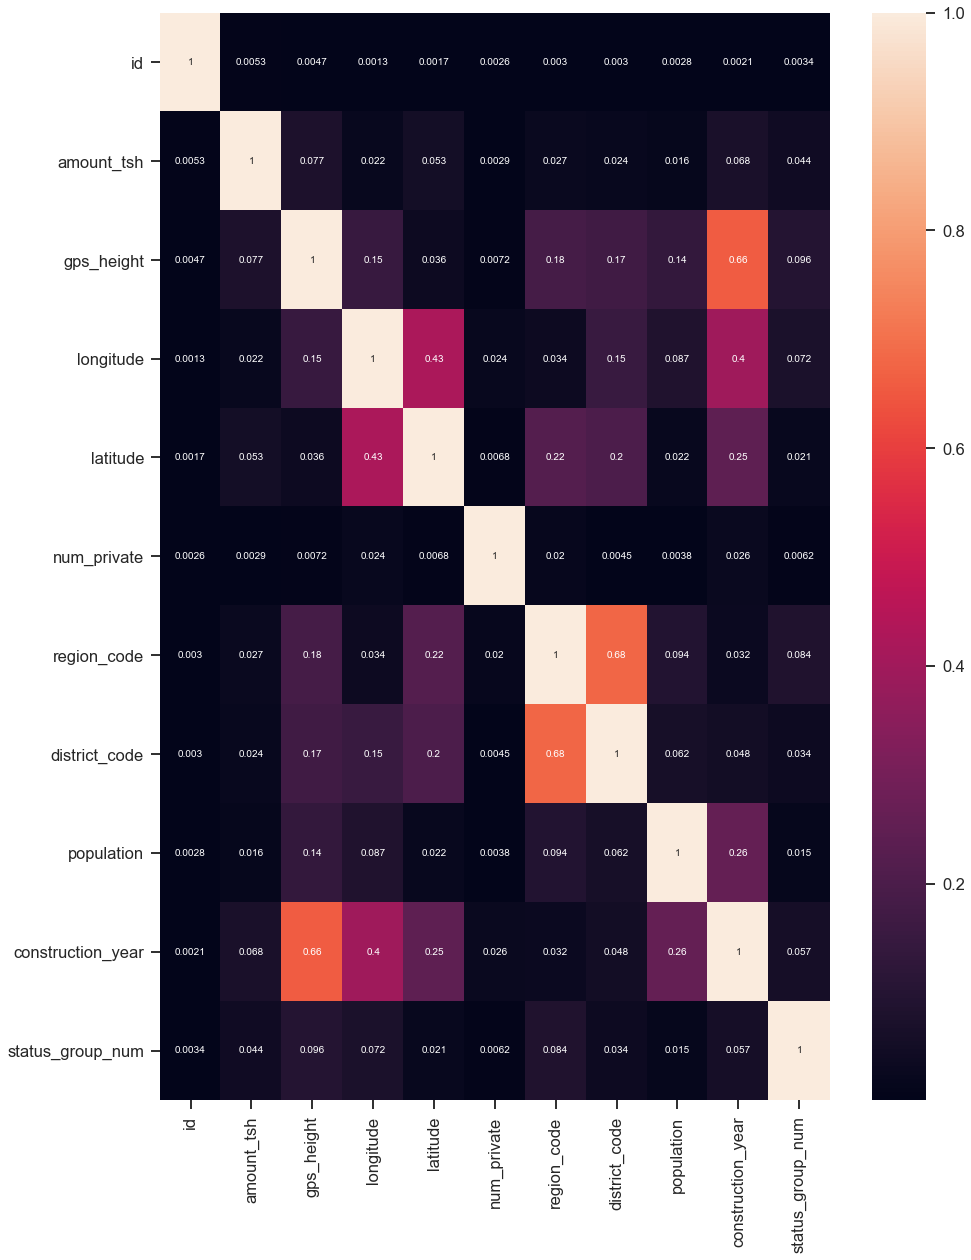

In [121]:
#Checking for any correlations on the initial data set
plt.figure(figsize=(15,20))
sns.heatmap(df1.corr().abs(), annot=True)
plt.show()

In [122]:
df2['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

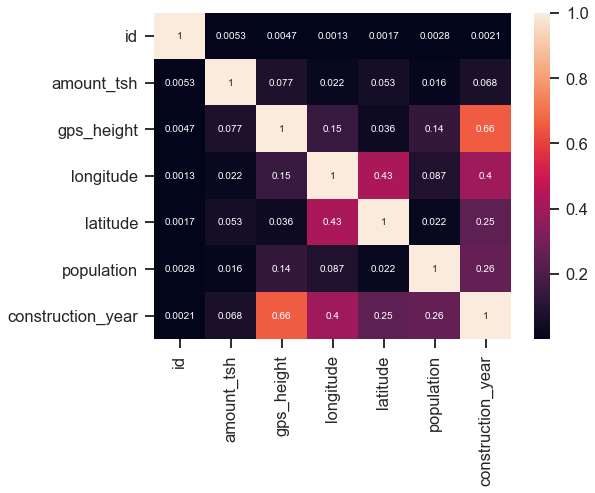

In [123]:
plt.figure(figsize=(8,6))
sns.heatmap(df2.corr().abs(), annot=True)
plt.show()

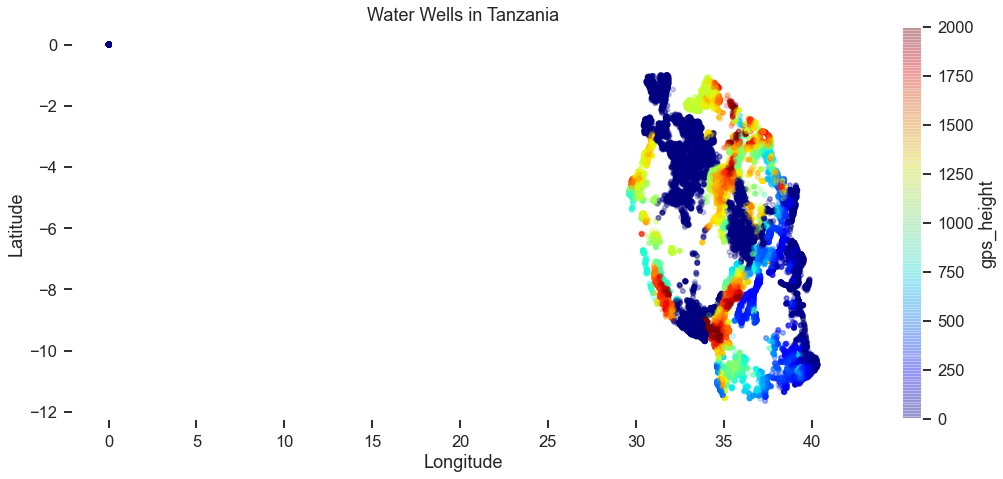

In [124]:
#Lat-Long heat map based on GPS Height
fig,ax = plt.subplots() 
plt.style.use('seaborn') 
sns.set_context('talk') 
df1.plot(kind = 'scatter',x = 'longitude', y = 'latitude', alpha = 0.2 , c = 'gps_height', cmap=plt.get_cmap('jet'), colorbar = True, vmin = 0, vmax = 2000, figsize = (15,7),ax=ax); 
ax.grid(False) 
ax.set_facecolor('White') 
ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude') 
ax.set_title('Water Wells in Tanzania'); 
plt.tight_layout()

In [125]:
# Looking at entry errors on longitude. Looks like there are a few might be missing?
df2['longitude'].value_counts()

0.000000     1812
39.088875       2
39.105307       2
37.543401       2
38.180538       2
             ... 
38.710520       1
40.117029       1
34.672962       1
39.433604       1
34.890838       1
Name: longitude, Length: 57516, dtype: int64

In [126]:
# Looking at entry errors on latitude. Looks like there are similar placeholder values as longitude.
df2['latitude'].value_counts()

-2.000000e-08    1812
-6.990549e+00       2
-2.489378e+00       2
-2.515321e+00       2
-6.963565e+00       2
                 ... 
-1.086099e+01       1
-3.149066e+00       1
-3.305834e+00       1
-9.076967e+00       1
-2.598965e+00       1
Name: latitude, Length: 57517, dtype: int64

In [127]:
# Removing placeholder values from longitude and latitude
df2 = df2[df2['longitude'] != 0]
df2 = df2[df2['latitude'] != -2.000000e-08]

In [128]:
df2['longitude'].value_counts()

39.105307    2
37.252194    2
37.250111    2
39.088875    2
37.318911    2
            ..
40.117029    1
34.672962    1
39.433604    1
35.901580    1
35.005922    1
Name: longitude, Length: 57515, dtype: int64

AttributeError: 'PathCollection' object has no property 'hue'

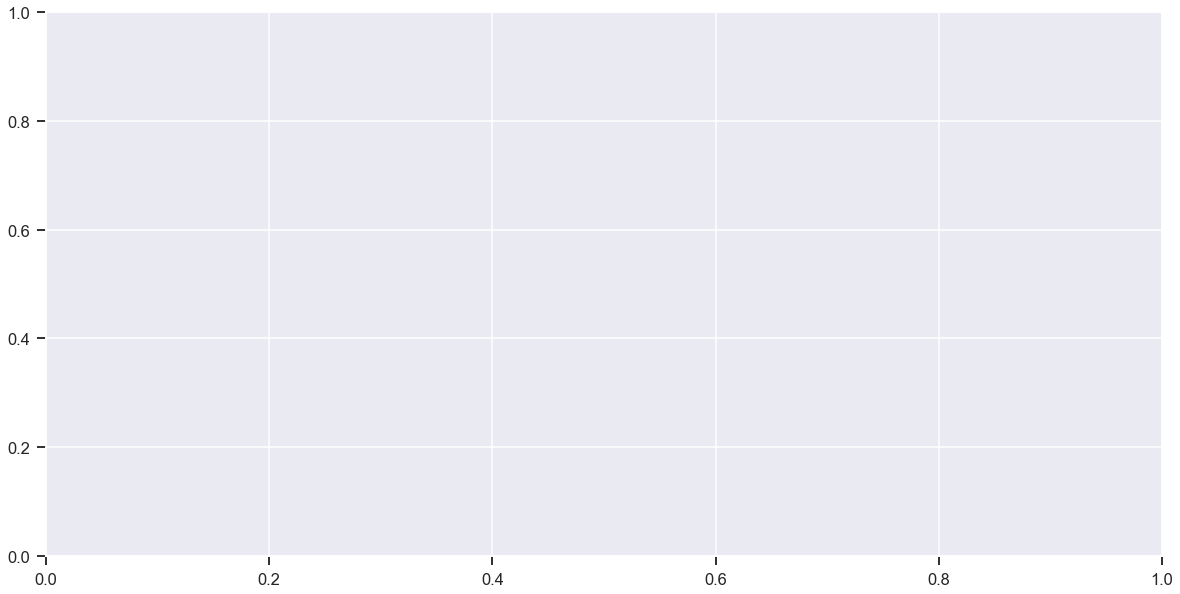

In [153]:
#Lat-Long heat map based on GPS Height w/o placeholders
fig,ax = plt.subplots() 
plt.style.use('seaborn') 
sns.set_context('talk') 
df2.plot(kind = 'scatter',x = 'longitude', y = 'latitude', alpha = 0.2 , c = 'gps_height', cmap=plt.get_cmap('jet'), colorbar = True, vmin = 0, vmax = 2000, figsize = (20,10),ax=ax); 
ax.grid(False) 
ax.set_facecolor('White') 
ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude') 
ax.set_title('Water Wells in Tanzania'); 
plt.tight_layout()

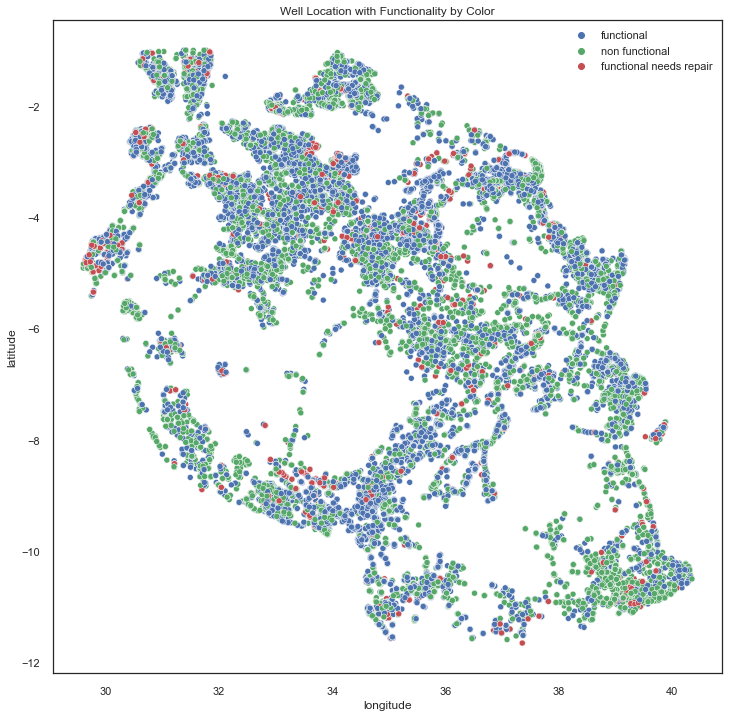

In [164]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='longitude', y='latitude', hue='status_group', data=df2, ax=ax)
sns.set_theme(style='white', palette=None)
plt.title('Well Location with Functionality by Color')
plt.legend(fancybox=True);

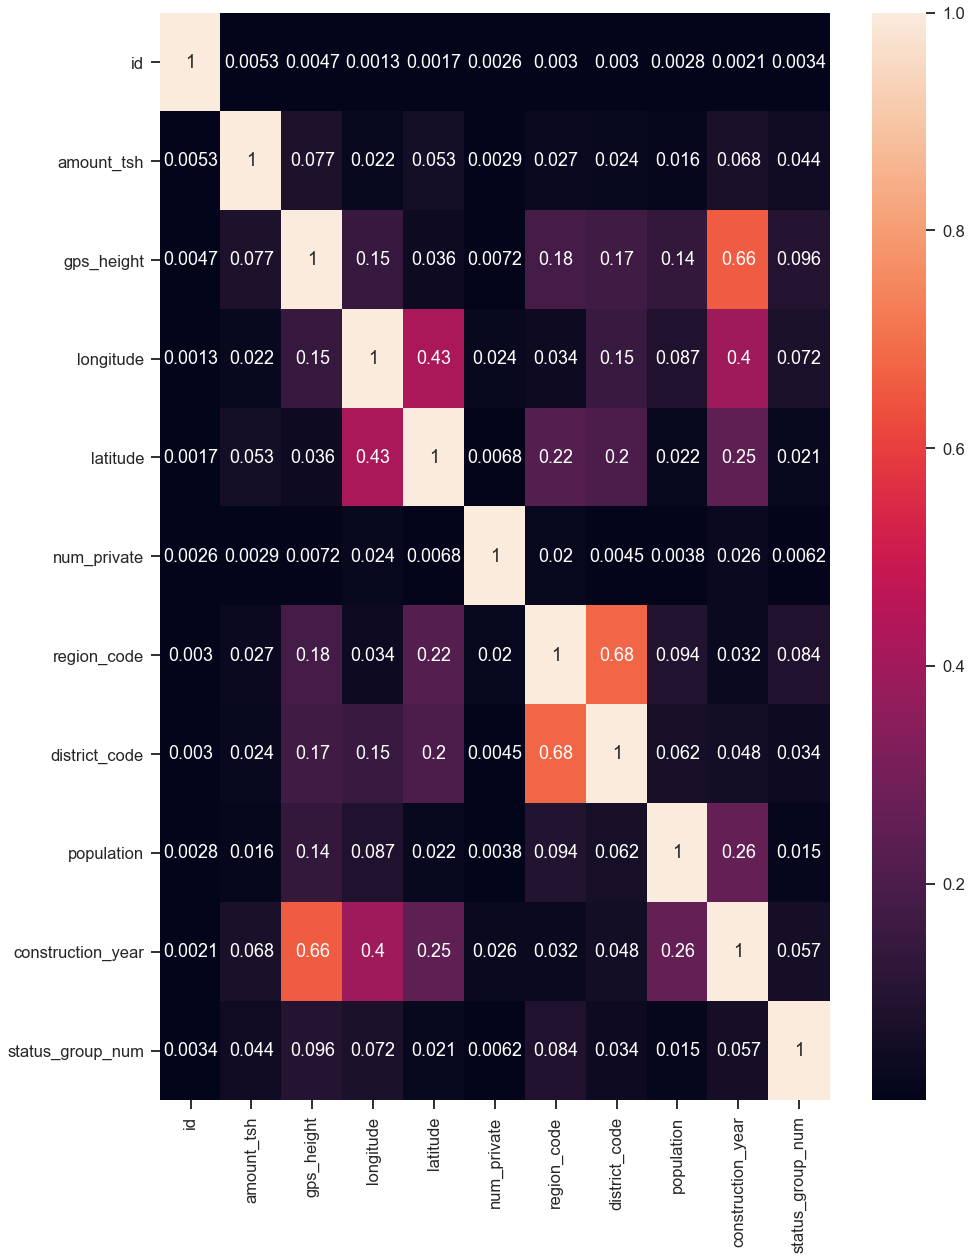

In [130]:
# Heatmap 
plt.figure(figsize=(15,20))
sns.heatmap(df1.corr().abs(), annot=True)
plt.show()

In [131]:
# Looks like population might be missing information?
pd.crosstab(df1['population'], df1['status_group'])

status_group,functional,functional needs repair,non functional
population,,,
0,11274,1775,8332
1,2911,354,3760
2,3,0,1
3,3,0,1
4,9,0,4
...,...,...,...
9865,0,0,1
10000,3,0,0
11463,1,0,0


## Mapping categorical values to numeric categorical values.

In [132]:
# Numeration of our target status group
status_group_map = {'functional': 0, 'non functional': 1, 'functional needs repair': 2}
df2['status_group_num'] = df2['status_group'].map(status_group_map)

In [133]:
# Numeration of payment_type
payment_num = {'never pay': 0, 'per bucket': 1, 'monthly': 2, 'unknown': 3, 
                               'on failure': 4, 'annually': 5, 'other': 6}
df2['payment_num'] = df2['payment_type'].map(payment_num)

In [134]:
df2['management'].value_counts()

vwc                 39746
wug                  5556
water board          2932
wua                  2533
private operator     1970
parastatal           1696
water authority       902
other                 840
company               685
unknown               551
other - school         99
trust                  78
Name: management, dtype: int64

In [135]:
# Numeration of management
management_num = {'vwc': 0, 'wug': 1, 'water board': 2, 'wua': 3, 'private operator': 4, 
              'parastatal': 5, 'water authority': 6, 'other':7, 'company': 8, 
              'unknown':9, 'other - school':10, 'trust':11}
df2['management_num'] = df2['management'].map(management_num)

In [136]:
# Numeration of permit
#permit_num = {False: 0, True: 1}
#df2['permit_num'] = df2['permit'].map(permit_num)
#df2['permit_num'] = df2['permit_num'].astype(int)

In [137]:
#df2['permit'].value_counts()

In [138]:
#mapping basin map
basin_map = {'Lake Victoria': 0,
             'Pangani': 1,
             'Rufiji': 2,
             'Internal': 3,
             'Lake Tanganyika': 4,
             'Wami / Ruvu': 5,
             'Lake Nyasa': 6,
             'Ruvuma / Southern Coast': 7,
             'Lake Rukwa': 8}

#adding in to df2
df2['basin_num'] = df2['basin'].map(basin_map)

In [139]:
# Numeration of quality_group
quality_group_map = {'good':1, 'salty':2, 'unknown':3, 'milky':4, 'colored':5, 'fluoride':6}
df2['qualtiy_group_num'] = df2['quality_group'].map(quality_group_map)

In [140]:
# Numeration of quantity
quantity_map = {'enough':0, 'insufficient':1, 'dry':2, 'seasonal':3, 'unknown':4}
df2['quantity_num'] = df2['quantity'].map(quantity_map)

In [141]:
# Numeration of source_type
source_type_num = {'spring':0, 'shallow well':1, 'borehole':2, 'river/lake':3, 'rainwater harvesting':4, 'dam':5, 'other':6}
df2['source_type_num'] = df2['source_type'].map(source_type_num)

In [142]:
# Numeration of waterpoint_type
waterpoint_type_map = {'communal standpipe':0, 'hand pump':1, 'other':2, 'communal standpipe multiple':3, 
                       'improved spring':4, 'cattle trough':5, 'dam':6}
df2['waterpoint_type_num'] = df2['waterpoint_type'].map(waterpoint_type_map)

In [143]:
# Numeration of region 
region_map = {'Iringa': 0,
             'Shinyanga': 1,
             'Mbeya': 2,
             'Kilimanjaro': 3,
             'Morogoro': 4,
             'Arusha': 5,
             'Kagera': 6,
             'Mwanza': 7,
             'Kigoma': 8,
             'Ruvuma': 9, 
             'Pwani': 10,
             'Tanga': 11,
             'Dodoma': 12,
             'Singida': 13,
             'Mara': 14,
             'Tabora': 15,
             'Rukwa': 16, 
             'Mtwara': 17,
             'Manyara': 18,
             'Lindi': 19,
             'Dar es Salaam': 20}

# Adding in to df2
df2['region_num'] = df2['region'].map(region_map)

In [144]:
#mapping extraction_type_class 
extraction_map = {'gravity': 0,
             'handpump': 1,
             'other': 2,
             'submersible': 3,
             'motorpump': 4,
             'rope pump': 5,
             'wind-powered': 6}

#adding in to df2
df2['extraction_num'] = df2['extraction_type_class'].map(extraction_map)

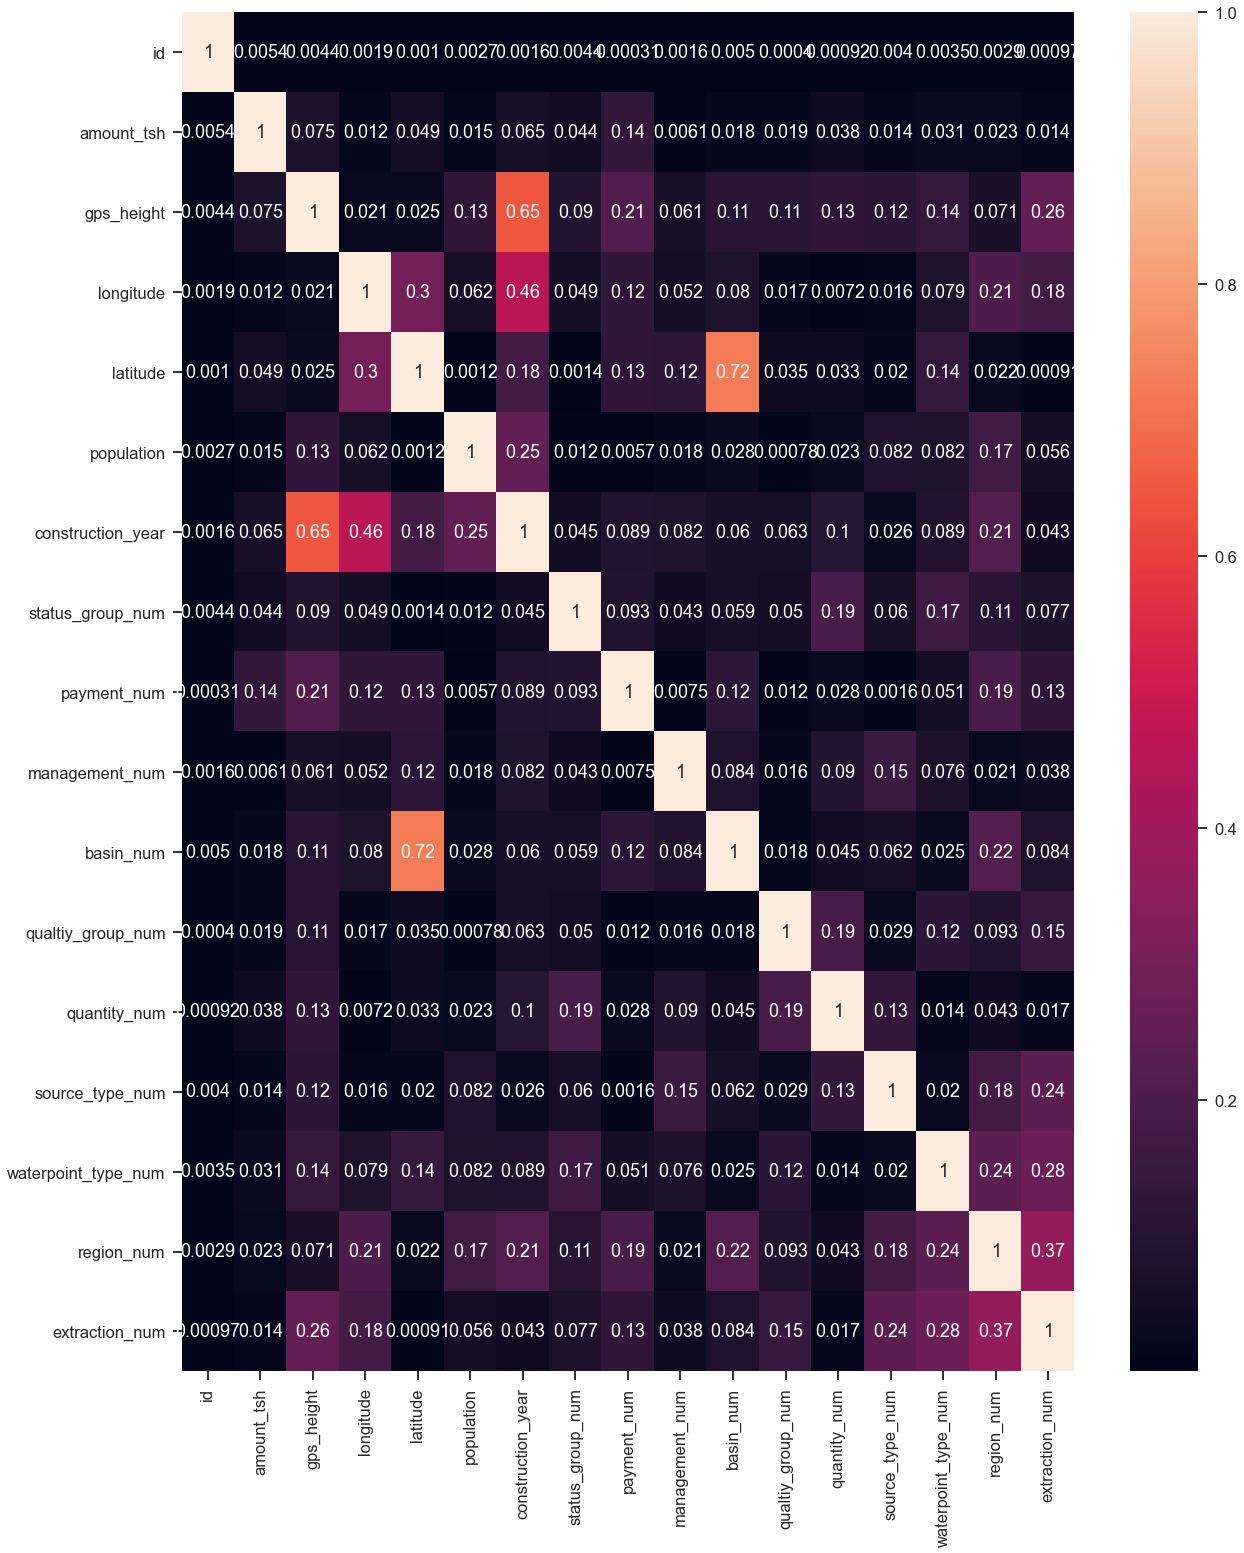

In [145]:
plt.figure(figsize=(20,25))
sns.heatmap(df2.corr().abs(), annot=True)
plt.show()

In [146]:
df2.columns

Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'subvillage', 'region', 'lga', 'ward',
       'population', 'permit', 'construction_year', 'extraction_type_class',
       'management', 'payment_type', 'quality_group', 'quantity',
       'source_type', 'waterpoint_type', 'status_group', 'status_group_num',
       'payment_num', 'management_num', 'basin_num', 'qualtiy_group_num',
       'quantity_num', 'source_type_num', 'waterpoint_type_num', 'region_num',
       'extraction_num'],
      dtype='object')

In [147]:
df2.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,...,status_group_num,payment_num,management_num,basin_num,qualtiy_group_num,quantity_num,source_type_num,waterpoint_type_num,region_num,extraction_num
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,...,0,5,0,6,1,0,0,0,0,0
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,...,0,0,1,0,1,1,4,0,14,0
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Majengo,Manyara,...,0,1,0,1,1,0,5,3,18,0
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,...,1,0,0,7,1,2,2,3,17,3
4,19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,...,0,0,7,0,1,3,4,0,6,0


In [148]:
# Creating numerical and categorical dataframe for EDA
numerical = df2[['amount_tsh', 'gps_height', 'longitude',
       'latitude', 'subvillage', 'region',
       'population', 'construction_year', 'status_group_num',
       'payment_num', 'management_num', 'basin_num', 'qualtiy_group_num',
       'quantity_num', 'source_type_num', 'waterpoint_type_num', 'region_num',
       'extraction_num']]

categorical = df2[['funder', 'installer', 'basin', 'subvillage', 
       'region', 'lga', 'ward',
       'permit', 'extraction_type_class',
       'management', 'payment_type', 'quality_group', 'quantity',
       'source_type', 'waterpoint_type', 'status_group']]

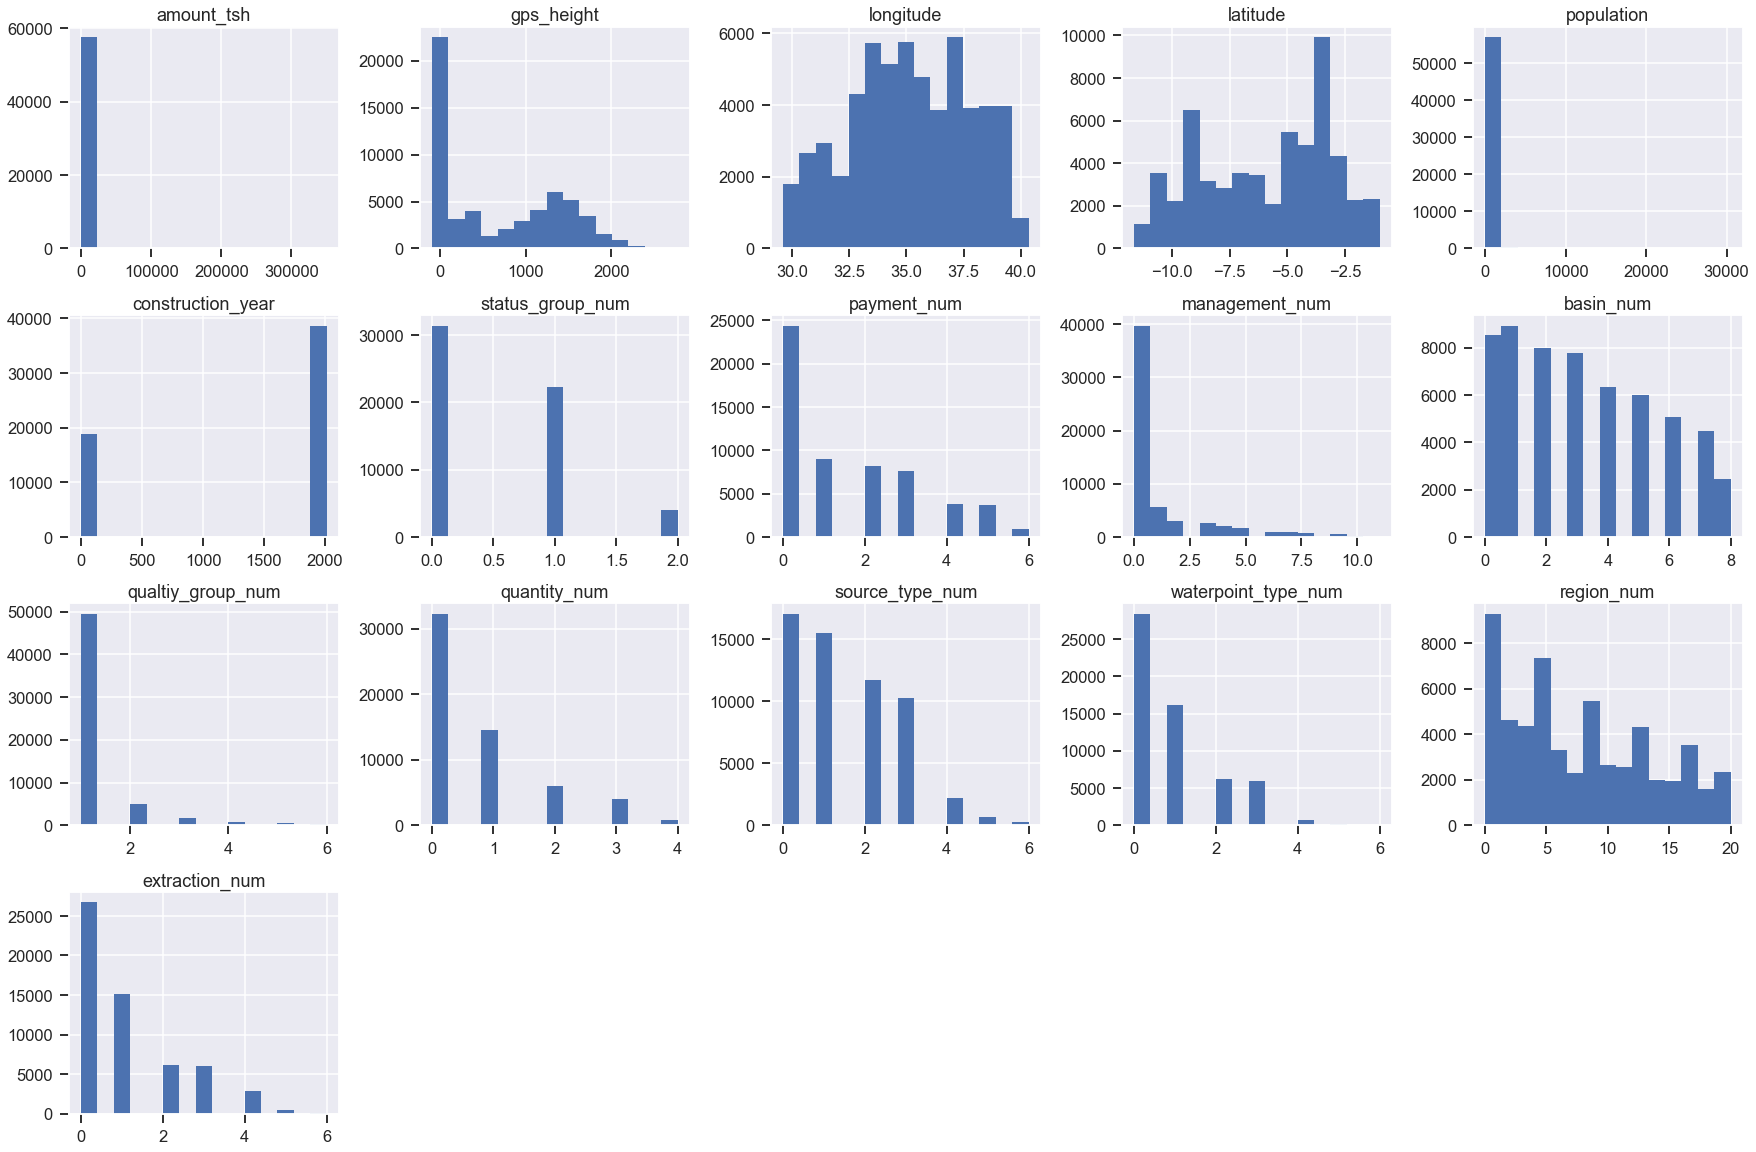

In [149]:
# Histogram EDA showing frequency of data
numerical.hist(bins=15, figsize=(30, 20), layout=(4, 5));

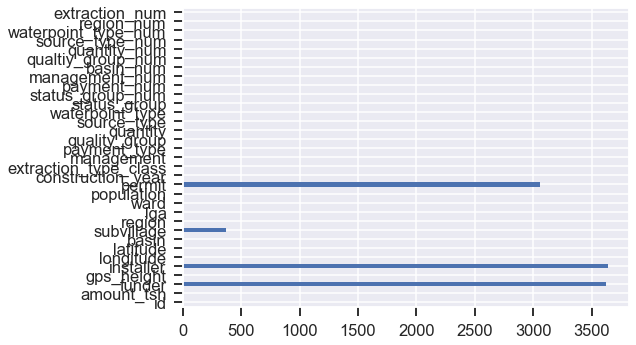

In [150]:
# EDA showing null values in our data set
df2.isnull().sum().plot(kind = 'barh');

In [151]:
df2.to_csv('eda_df.csv')